<a href="https://colab.research.google.com/github/sera0911/asia_ai_study/blob/main/New_MachinLearning/exam_12_1_another_company_predict_daliy_stock_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##삼성전자 데이터의 컬럼을 모두 사용해 예측하기(LSTM, RNN 사용하여 시계열 데이터 예측하기)

In [6]:
#모듈 불러오기

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *  #레이어 전체를 가져온다
from tensorflow.keras.optimizers import Adam

In [7]:
#파일 불러오기(삼성 주식 데이터)
raw_data = pd.read_csv('호텔신라.csv')
print(raw_data.head())

         Date     Open     High      Low    Close     Adj Close  Volume
0  2020-06-15  76100.0  76200.0  72400.0  72500.0  72319.203125  830788
1  2020-06-16  73500.0  74500.0  73500.0  74000.0  73815.460938  426501
2  2020-06-17  73400.0  73800.0  72000.0  72300.0  72119.703125  516721
3  2020-06-18  72000.0  72100.0  70700.0  70900.0  70723.195313  575467
4  2020-06-19  71100.0  72600.0  70900.0  72000.0  71820.453125  584062


In [8]:
raw_data['Date'] = pd.to_datetime(raw_data['Date'])  #데이트 타입으로 변환
raw_data.set_index('Date', inplace=True)  #날짜를 인덱스로 지정
print(raw_data.head())

               Open     High      Low    Close     Adj Close  Volume
Date                                                                
2020-06-15  76100.0  76200.0  72400.0  72500.0  72319.203125  830788
2020-06-16  73500.0  74500.0  73500.0  74000.0  73815.460938  426501
2020-06-17  73400.0  73800.0  72000.0  72300.0  72119.703125  516721
2020-06-18  72000.0  72100.0  70700.0  70900.0  70723.195313  575467
2020-06-19  71100.0  72600.0  70900.0  72000.0  71820.453125  584062


In [13]:
#Adj Close는 close와 값이 비슷해서 빼주기위해서 drop시킨다
data = raw_data.drop(['Adj Close'], axis=1)
print(data.head())
print(data.info())
print(data.shape)

               Open     High      Low    Close  Volume
Date                                                  
2020-06-15  76100.0  76200.0  72400.0  72500.0  830788
2020-06-16  73500.0  74500.0  73500.0  74000.0  426501
2020-06-17  73400.0  73800.0  72000.0  72300.0  516721
2020-06-18  72000.0  72100.0  70700.0  70900.0  575467
2020-06-19  71100.0  72600.0  70900.0  72000.0  584062
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 2020-06-15 to 2021-06-14
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    248 non-null    float64
 1   High    248 non-null    float64
 2   Low     248 non-null    float64
 3   Close   248 non-null    float64
 4   Volume  248 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 21.6 KB
None
(248, 5)


In [15]:
#데이터 스케일링하기
from sklearn.preprocessing import MinMaxScaler

minmaxscaler = MinMaxScaler()
scaled_data = minmaxscaler.fit_transform(data)  #MinMaxScaler로 변환시키기
print(scaled_data[:5])
print(scaled_data.shape)

[[0.26162791 0.23428571 0.19104478 0.18309859 0.19009705]
 [0.18604651 0.18571429 0.2238806  0.22535211 0.07031381]
 [0.18313953 0.16571429 0.17910448 0.17746479 0.09704443]
 [0.14244186 0.11714286 0.14029851 0.13802817 0.11444985]
 [0.11627907 0.13142857 0.14626866 0.16901408 0.1169964 ]]
(248, 5)


In [18]:
sequence_X = []
sequence_Y = []

#시계열 데이터를 원하는 크기만큼 잘라서(28) 그 다음숫자를 타켓으로 지정해놓기(29)
for i in range(len(scaled_data) - 28):
    _x = scaled_data[i : i + 28]
    _y = scaled_data[i + 28][3]  #3번인덱스가 close(종가)
    if i is 0:   #처음 for문을 확인해보기 (잘나오는지=1~28 다음 29번째가 나오는지)
        print(_x, '->', _y)
    sequence_X.append(_x)
    sequence_Y.append(_y)

#결과 중 0은 최저가 라는 뜻

[[0.26162791 0.23428571 0.19104478 0.18309859 0.19009705]
 [0.18604651 0.18571429 0.2238806  0.22535211 0.07031381]
 [0.18313953 0.16571429 0.17910448 0.17746479 0.09704443]
 [0.14244186 0.11714286 0.14029851 0.13802817 0.11444985]
 [0.11627907 0.13142857 0.14626866 0.16901408 0.1169964 ]
 [0.13081395 0.10285714 0.12835821 0.12112676 0.10004548]
 [0.09883721 0.09428571 0.10149254 0.09859155 0.10027302]
 [0.07848837 0.06571429 0.10447761 0.10985915 0.04497186]
 [0.06104651 0.04       0.06567164 0.07042254 0.08541919]
 [0.05523256 0.03714286 0.06567164 0.07605634 0.0545889 ]
 [0.02325581 0.         0.         0.         0.11712381]
 [0.         0.18       0.01791045 0.14084507 0.92163204]
 [0.12790698 0.1        0.08059701 0.07887324 0.12970545]
 [0.0494186  0.10285714 0.08358209 0.14366197 0.10168452]
 [0.13081395 0.10857143 0.12537313 0.13802817 0.04086242]
 [0.11046512 0.08857143 0.11641791 0.13521127 0.02608917]
 [0.125      0.11428571 0.13731343 0.14929577 0.05100803]
 [0.10755814 0

In [20]:
#모델에게 주기 위해 np.array타입으로 변환(스케일링하면 데이터프레임이 사라져서)

sequence_X = np.array(sequence_X)
sequence_Y = np.array(sequence_Y)
print(sequence_X[0])
print(sequence_Y[0])
print(sequence_X.shape)  #248개의 데이터에서 28개 빼서 220개의 데이터 , 28개가 한개씩 묶인 리스트 220개, 컬럼이 5개
print(sequence_Y.shape)  #타켓값 , 220개

[[0.26162791 0.23428571 0.19104478 0.18309859 0.19009705]
 [0.18604651 0.18571429 0.2238806  0.22535211 0.07031381]
 [0.18313953 0.16571429 0.17910448 0.17746479 0.09704443]
 [0.14244186 0.11714286 0.14029851 0.13802817 0.11444985]
 [0.11627907 0.13142857 0.14626866 0.16901408 0.1169964 ]
 [0.13081395 0.10285714 0.12835821 0.12112676 0.10004548]
 [0.09883721 0.09428571 0.10149254 0.09859155 0.10027302]
 [0.07848837 0.06571429 0.10447761 0.10985915 0.04497186]
 [0.06104651 0.04       0.06567164 0.07042254 0.08541919]
 [0.05523256 0.03714286 0.06567164 0.07605634 0.0545889 ]
 [0.02325581 0.         0.         0.         0.11712381]
 [0.         0.18       0.01791045 0.14084507 0.92163204]
 [0.12790698 0.1        0.08059701 0.07887324 0.12970545]
 [0.0494186  0.10285714 0.08358209 0.14366197 0.10168452]
 [0.13081395 0.10857143 0.12537313 0.13802817 0.04086242]
 [0.11046512 0.08857143 0.11641791 0.13521127 0.02608917]
 [0.125      0.11428571 0.13731343 0.14929577 0.05100803]
 [0.10755814 0

In [21]:
#학습과 테스트용으로 분할
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    sequence_X, sequence_Y, test_size=0.2, random_state=77)  #random_state= 난수의 초기값 설정. 랜덤값을 뽑아주긴 하지만, 같은 결과를 보여주기 위해(데이터가 적을 땐 없으면 결과가 크게 달라진다)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(176, 28, 5)
(176,)
(44, 28, 5)
(44,)


In [22]:
#모델 생성

model = Sequential() #시퀀스란 데이터를 순서대로 하나씩 나열하여 나타낸 데이터 구조

#input_shape=(X_train.shape[0], X_train.shape[1]) 인 이유는 자르는 갯수가 달라지더라도 train.shape로 해놓으면 변경되는 대로 적용되서(현재 적용된 건(28, 1))
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'))  #LSTM 일 때는 activation='thah'로 해줘야 한다(하이퍼볼릭 탄젠트)
#RNN을 사용하고 싶다면 SimpleRNN을 사용하면 된다, GRU는 한국인이 만든 것(속도가 더 빠르다)
model.add(Flatten())  #1차원으로 변형해주는 flatten
model.add(Dense(1))  #값 자체를 예측하기 때문에 activation을 사용하지 않는다

model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11200     
_________________________________________________________________
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#모델 학습

#validation_data=(X_test, Y_test) = 학습시에 테스트를 test데이터로 사용해도된다 (validation_data는 모델학습은 안시키고 테스트 역할로만 사용하기 때문에)
fit_hist = model.fit(X_train, Y_train, epochs=350, validation_data=(X_test, Y_test), shuffle=False)

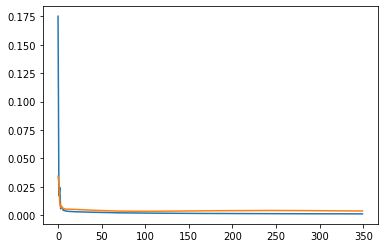

In [24]:
#오차를 그래프로 그려보기

plt.plot(fit_hist.history['loss'])
plt.plot(fit_hist.history['val_loss'])
plt.show()

In [ ]:
#X_test 예측하기

predict = model.predict(X_test)

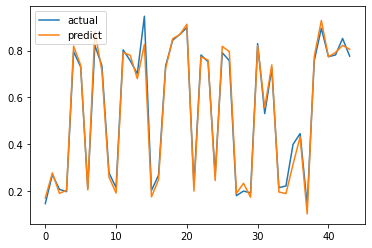

In [ ]:
plt.plot(Y_test, label='actual')  #실제 타겟Y값
plt.plot(predict, label='predict')  #모델학습으로 예측한 X_test값
plt.legend()
plt.show()

## 만든 모델로 오늘의 삼성전자 주가 예측하기

In [29]:
#최근 2달간의 데이터만 사용해본다

test_data = raw_data['2021-04-15' : '2021-06-14'][['Open', 'High', 'Low', 'Close', 'Volume']]
print(test_data.head())
print(test_data.tail())
print(test_data.info())
print(test_data.shape)

               Open     High      Low    Close  Volume
Date                                                  
2021-04-15  83800.0  84400.0  83300.0  83700.0  382971
2021-04-16  84100.0  84300.0  83700.0  84000.0  287056
2021-04-19  84000.0  84000.0  83200.0  83900.0  342405
2021-04-20  83900.0  85000.0  83900.0  85000.0  355885
2021-04-21  84400.0  84400.0  83600.0  83700.0  320296
                Open      High      Low    Close   Volume
Date                                                     
2021-06-08   97600.0   98200.0  96800.0  97500.0   426957
2021-06-09   97600.0  102000.0  97400.0  99900.0  1065288
2021-06-10  100500.0  101000.0  99100.0  99400.0   611096
2021-06-11   99800.0  100500.0  98100.0  98700.0   424570
2021-06-14   99000.0   99600.0  98400.0  98800.0   365231
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41 entries, 2021-04-15 to 2021-06-14
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    

In [31]:
#데이터 스케일링 

scaled_test_data = minmaxscaler.transform(test_data)  #transform은 이미 fit된 것으로 값만 바꿔주는 것
# 학습 데이터 세트로 fit() 된 Scaler를 이용하여 테스트 데이터를 변환할 경우에는  테스트 데이터에서 다시 fit()하지 않고 반드시 그대로 이 Scaler를 이용하여 transform()을 수행해야 한다
print(scaled_test_data[-5:])
print(scaled_test_data.shape)

[[0.88662791 0.86285714 0.91940299 0.88732394 0.07044891]
 [0.88662791 0.97142857 0.93731343 0.95492958 0.25957534]
 [0.97093023 0.94285714 0.9880597  0.94084507 0.12500611]
 [0.9505814  0.92857143 0.95820896 0.92112676 0.06974169]
 [0.92732558 0.90285714 0.96716418 0.92394366 0.05216057]]
(41, 5)


In [33]:
scaled_test_data[39][3]  #임의의 날짜로 종가 출력해보기, 이때 스케일링이 된 상태라 종가가 얼마인지 알아볼 수 없다

0.9211267605633806

In [34]:
#스케일링 된 데이터를 다시 변환시켜서 원가 확인해보기
predict_value = minmaxscaler.inverse_transform(scaled_test_data[39].reshape(-1, 5)) #inverse_transform= 위 문제를 해결하기 위해 원래 값으로 되돌리라는 것
print(predict_value)

[[ 99800. 100500.  98100.  98700. 424570.]]


In [35]:
print(test_data.iloc[39])

Open       99800.0
High      100500.0
Low        98100.0
Close      98700.0
Volume    424570.0
Name: 2021-06-11 00:00:00, dtype: float64


In [36]:
#데이터 스케일링, feature, target 시퀀스화

sequence_testdata_X = []
sequence_testdata_Y = []
for i in range(len(scaled_test_data) - 28):
    _x = scaled_test_data[i : i + 28]
    _y = scaled_test_data[i+28][3]
    sequence_testdata_X.append(_x)
    sequence_testdata_Y.append(_y)

#ndarray로 변환
sequence_testdata_X = np.array(sequence_testdata_X)
sequence_testdata_Y = np.array(sequence_testdata_Y)

print(sequence_testdata_X.shape)
print(sequence_testdata_Y.shape)

(13, 28, 5)
(13,)


In [37]:
predict = model.predict(sequence_testdata_X)

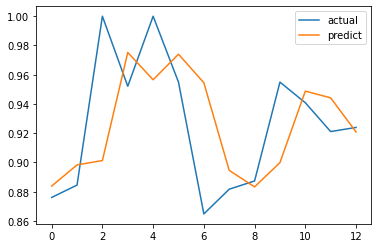

In [38]:
plt.plot(sequence_testdata_Y, label='actual')
plt.plot(predict, label='predict')
plt.legend()

In [39]:
last_28_data = scaled_test_data[-28:]
last_28_data.shape

(28, 5)

In [40]:
last_28_data = last_28_data.reshape(-1, 28, 5)
last_28_data.shape

(1, 28, 5)

In [41]:
today_close = model.predict(last_28_data)
print(today_close)

[[0.9139785]]


In [42]:
#종가만 스케일링해주는 스케일러를 만들어주기(위에는 5개의 컬럼을 다 넣고 스케일링을 만든거라 여기서 사용불가)

minmaxscaler_close = MinMaxScaler()
_ = minmaxscaler_close.fit_transform(data[['Close']])  #data= 2019-06 ~ 2020-06 데이터
today_close = minmaxscaler_close.inverse_transform(today_close)
print(today_close)

[[98446.24]]
